In [ ]:
# default_exp data

# cheviz data

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

We create a data directory and fetch some annotated PGNs of top tier chess tournaments.

In [ ]:
!mkdir -p data
!ls

00_core.ipynb  CONTRIBUTING.md	index.ipynb  MANIFEST.in       settings.ini
01_data.ipynb  data		LICENSE      README.md	       setup.py
cheviz	       docs		Makefile     requirements.txt


In Jupyter there is that nice `!some shell command` escape hatch that would allow us to simply use `curl` or `wget`. However, we cannot use the escape hatch in code we want to export as a module. So we use urllib and shutil instead. Because of Python's `with ... as ...` pattern this produces unexpectedly elegant code (which I didn't come up with myself but found on [stack overflow, obviously](https://stackoverflow.com/questions/7243750/download-file-from-web-in-python-3/7244263#7244263)).

In [ ]:
#export
from pathlib import Path
import urllib.request
import shutil

def fetch()->dict:
    result = {}
    url_prefix = 'https://pgnchessbook.org/wp-content/uploads/2019/08/'
    data_files = ['WorldChamp_1986_to_2018.pgn', 'Candidates_1953.pgn', 'WijkaanZee2019.pgn', 'Shamkir2019.pgn', 'Baden2019.pgn']
    
    for file in data_files:
        src = url_prefix + file
        dst = Path().absolute() / 'data' / file
        if not dst.is_file():
            with urllib.request.urlopen(src) as response, open(dst, 'wb') as dst_file:
                shutil.copyfileobj(response, dst_file)
            
        if dst.is_file():
            result[file] = dst
            
    return result

In [ ]:
data = fetch()
!ls data

Baden2019.pgn	     Shamkir2019.pgn	 WorldChamp_1986_to_2018.pgn
Candidates_1953.pgn  WijkaanZee2019.pgn


In [ ]:
!du -sh data

756K	data


Now that we downloaded our chess games, we wrap the chess.pgn parser in a generator. Notice that a single PGN file can contain multiple chess games, as is the case with our tournament archives. 

In [ ]:
#export
import chess.pgn

def games(pgn_name:str)->chess.pgn.Game:
    with open(pgn_name, 'r') as pgn_file:
        games_read = []
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            
            yield (game.board(), game.mainline_moves(), game.headers)

On my machine, it takes roughly a second to parse all games of the 1953 world championship candidate tournament. This is probably slow considering the PGN file has a size of only 120kb. As data scientists we learn to ignore what could otherwise annoy us as software engineers – after all, we need automated insights, not a fast PGN parser.

In [ ]:
pgn = {}
key = 'Candidates_1953.pgn'

%time pgn[key] = list(games(data[key]))   
board, moves, header = pgn[key][0]
board, moves, header

CPU times: user 767 ms, sys: 4.02 ms, total: 771 ms
Wall time: 772 ms


(Board('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'),
 <Mainline at 0x7fd0c284a1d0 (1. c4 Nf6 2. g3 e6 3. Bg2 d5 4. d4 dxc4 5. Qa4+ Nbd7 6. Nf3 a6 7. Qxc4 b5 8. Qc6 Rb8 9. Bf4 Nd5 10. Bg5 Be7 11. Bxe7 Qxe7 12. O-O Bb7 13. Qc2 c5 14. dxc5 Nxc5 15. Rc1 Rc8 16. Nc3 Nf6 17. b4 Na4 18. Qb3 Nxc3 19. Rxc3 Rxc3 20. Qxc3 O-O 21. Rc1 Rd8 22. a3 Nd5 23. Qd4 f6 24. Ne1 e5 25. Qc5 Qxc5 26. bxc5 Bc6 27. Rd1 Rd7 28. Bh3 Re7 29. Nc2 a5 30. Bg2 Rd7 31. Bh3 Re7 32. Kf1 Kf7 33. Ke1 Rc7 34. Rd3 Bb7 35. Ne3 Rxc5 36. Nf5 Bc6 37. Nd6+ Kf8 38. Bg2 g6 39. Kd2 Ke7 40. Ne4 Rc4 41. f3 f5 42. Nf2 Ra4 43. Nd1 e4 44. fxe4 fxe4 45. Rb3 Rd4+ 46. Kc1 b4 47. Ne3 Nc3 48. axb4 Nxe2+ 49. Kb1 Ba4 50. Rb2 Nc3+ 51. Kc1 axb4 52. Rd2 Rxd2 53. Kxd2 Kd6 54. Ng4 Kc5 55. h4 Kd4 56. h5 gxh5 57. Ne3 Nb1+ 58. Ke2 Bb5+ 59. Kf2 b3)>,
 Headers(Event='ct', Site='Zurich', Date='1953.??.??', Round='01', White='Szabo L', Black='Geller E', Result='0-1'))

In [ ]:
type(board), type(moves), type(header)

(chess.Board, chess.pgn.Mainline, chess.pgn.Headers)

Our PGN archive has been parsed into a list of games, grouped by tournament. Each game is represented by a tuple, `(chess.Board, chess.pgn.Mainline, chess.pgn.Headers)`. The game meta data is stored in `chess.pgn.Headers`,  following the Seven Tag Roster scheme, or STR. `chess.Board` contains the current position, `chess.pgn.Mainline` contains all mainline moves. 

We already know how to visualize a single position, for each side.

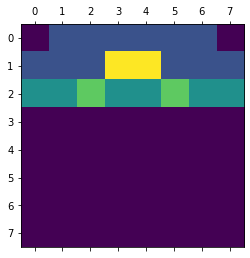

In [ ]:
from cheviz import core

ts = core.makeThreatenedSquares(board=board)
core.show(ts(chess.BLACK))

To advance the board by a move, we push the next move of the mainline onto the board.

In [ ]:
moves_list = list(moves)
moves_list[0]

Move.from_uci('c2c4')

Notice that a repeating push of the same move will corrupt the board configuration. We need to carefully reset the board configuration by either popping the last move from the move stack or resetting the move stack entirely.

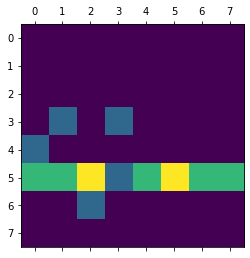

In [ ]:
board.reset()
board.push(moves_list[0])
core.show(ts(chess.WHITE, core.attack))